<a href="https://colab.research.google.com/github/eriksali/DNN_2023_DL/blob/main/a3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1,   200] loss: 1.609
[1,   400] loss: 1.603
[2,   200] loss: 1.567
[2,   400] loss: 1.236
[3,   200] loss: 0.717
[3,   400] loss: 0.588
[4,   200] loss: 0.536
[4,   400] loss: 0.514
[5,   200] loss: 0.502
[5,   400] loss: 0.489


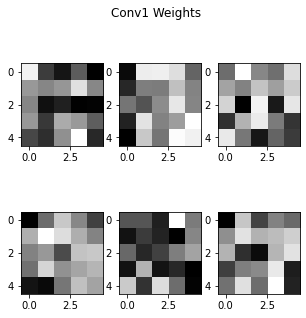

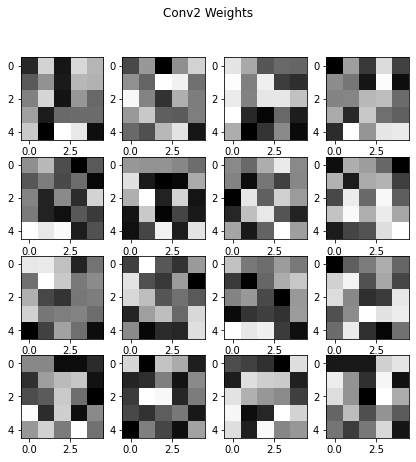

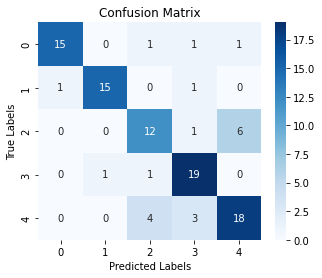

In [16]:
## input image size = 28x28, input channel = 1, 
## filter size = 5x5, padding=2, conv (6); 
## 2x2, stride = 2, avgpool; 
## 5x5, conv (16); 
## 2x2, stride=2, avgpool;
## fc(120, fc(84), fc(5)


import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

# classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
selected_classes = [0, 1, 2, 3, 4]

# Create a custom subset that contains only the selected classes
selected_indices = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if label in selected_classes:
        selected_indices.append(i)

selected_train_dataset = Subset(train_dataset, selected_indices)

batch_size = 64
selected_train_loader = DataLoader(selected_train_dataset, batch_size=batch_size, shuffle=True)

# Create a custom subset that contains only the selected classes
selected_indices = []
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label in selected_classes:
        selected_indices.append(i)

selected_test_dataset = Subset(test_dataset, selected_indices)

import random


# Select a random subset of 100 images from the test dataset

test_subset_indices = random.sample(range(len(selected_test_dataset)), k=100)
test_subset = Subset(selected_test_dataset, test_subset_indices)


batch_size = 64
selected_test_loader     = DataLoader(selected_test_dataset, batch_size=batch_size, shuffle=True)
selected_test_loader_100 = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

# Define function to flip images horizontally or vertically
def flip_images(images, mode='horizontal'):
    if mode == 'horizontal':
        return torch.flip(images, dims=[3])
    elif mode == 'vertical':
        return torch.flip(images, dims=[2])
    else:
        raise ValueError("Invalid mode")

# Flip test images vertically and measure accuracy
test_subset_flipped_vertical = [(flip_images(images, mode='vertical'), labels) for images, labels in test_subset]
test_loader_flipped_vertical = torch.utils.data.DataLoader(test_subset_flipped_vertical, batch_size)


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=5)
        
    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 16*5*5)
        
        # Fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        
        return x

net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(selected_train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

# Extract the weights of the filters in both convolutional layers
conv1_weights = net.conv1.weight.detach().clone()
conv2_weights = net.conv2.weight.detach().clone()

import matplotlib.pyplot as plt

# Define the function to extract and visualize the weights of the filters
def visualize_filters(net):
    conv1_weights = net.conv1.weight.detach().cpu().numpy()
    conv2_weights = net.conv2.weight.detach().cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(5,5))
    fig.suptitle('Conv1 Weights')
    for i in range(2):
        for j in range(3):
            axs[i, j].imshow(conv1_weights[i*3+j][0], cmap='gray')
            #axs[i, j].axis('off')

    fig, axs = plt.subplots(4, 4, figsize=(7,7))
    fig.suptitle('Conv2 Weights')
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(conv2_weights[i*4+j][0], cmap='gray')
            #axs[i, j].axis('off')

visualize_filters(net)

path = F"/content/cnn_model_5.pt" 
torch.save(net.state_dict(), path)

predictions = []
true_labels = []
with torch.no_grad():
    ##for inputs, labels in selected_test_loader: # Test on selected 5 classes dataset
    for inputs, labels in test_loader_flipped_vertical: # Test on flipped dataset
    ##for inputs, labels in selected_test_loader_100: # Test on a random subset of 100 images from the selected test dataset
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted)
        true_labels.append(labels)

predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=selected_classes)

plt.figure(figsize=(5, 4))
#sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [7]:
from torchsummary import summary

model = Net()
batch_size = 64
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 5]             425
Total params: 61,281
Trainable params: 61,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


[1,   200] loss: 1.609
[1,   400] loss: 1.604
[2,   200] loss: 1.595
[2,   400] loss: 1.574
[3,   200] loss: 1.303
[3,   400] loss: 0.811
[4,   200] loss: 0.563
[4,   400] loss: 0.545
[5,   200] loss: 0.506
[5,   400] loss: 0.490


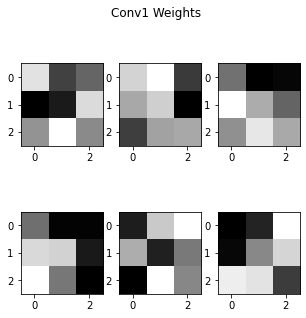

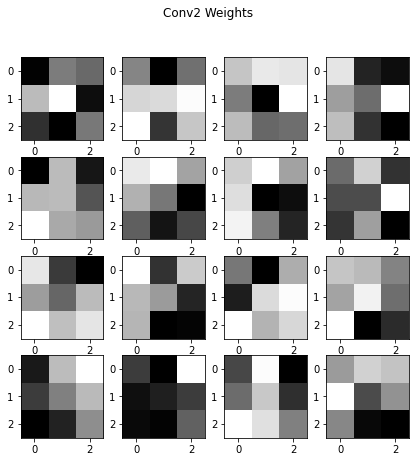

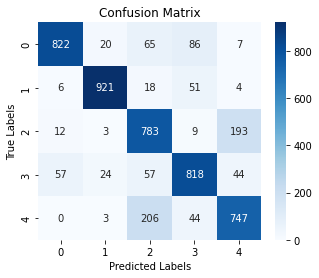

In [18]:
## input image size = 28x28, input channel = 1, 
## filter size = 3x3, padding=2, conv (6); 
## 2x2, stride = 2, avgpool; 
## 3x3, padding= 1, conv (16); 
## 2x2, stride = 2, avgpool;
## fc(120, fc(84), fc(5)


import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

# classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
selected_classes = [0, 1, 2, 3, 4]

# Create a custom subset that contains only the selected classes
selected_indices = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if label in selected_classes:
        selected_indices.append(i)

selected_train_dataset = Subset(train_dataset, selected_indices)

batch_size = 64
selected_train_loader = DataLoader(selected_train_dataset, batch_size=batch_size, shuffle=True)

# Create a custom subset that contains only the selected classes
selected_indices = []
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label in selected_classes:
        selected_indices.append(i)

selected_test_dataset = Subset(test_dataset, selected_indices)

import random


# Select a random subset of 100 images from the test dataset

test_subset_indices = random.sample(range(len(selected_test_dataset)), k=100)
test_subset = Subset(selected_test_dataset, test_subset_indices)


batch_size = 64
selected_test_loader     = DataLoader(selected_test_dataset, batch_size=batch_size, shuffle=True)
selected_test_loader_100 = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

# Define function to flip images horizontally or vertically
def flip_images(images, mode='horizontal'):
    if mode == 'horizontal':
        return torch.flip(images, dims=[3])
    elif mode == 'vertical':
        return torch.flip(images, dims=[2])
    else:
        raise ValueError("Invalid mode")

# Flip test images vertically and measure accuracy
test_subset_flipped_vertical = [(flip_images(images, mode='vertical'), labels) for images, labels in test_subset]
test_loader_flipped_vertical = torch.utils.data.DataLoader(test_subset_flipped_vertical, batch_size)


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=16*6*6, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=5)
        
    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 16*6*6)
        
        # Fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        
        return x

net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(selected_train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

# Extract the weights of the filters in both convolutional layers
conv1_weights = net.conv1.weight.detach().clone()
conv2_weights = net.conv2.weight.detach().clone()

import matplotlib.pyplot as plt

# Define the function to extract and visualize the weights of the filters
def visualize_filters(net):
    conv1_weights = net.conv1.weight.detach().cpu().numpy()
    conv2_weights = net.conv2.weight.detach().cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(5,5))
    fig.suptitle('Conv1 Weights')
    for i in range(2):
        for j in range(3):
            axs[i, j].imshow(conv1_weights[i*3+j][0], cmap='gray')
            #axs[i, j].axis('off')

    fig, axs = plt.subplots(4, 4, figsize=(7,7))
    fig.suptitle('Conv2 Weights')
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(conv2_weights[i*4+j][0], cmap='gray')
            #axs[i, j].axis('off')

visualize_filters(net)

path = F"/content/cnn_model_5.pt" 
torch.save(net.state_dict(), path)

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in selected_test_loader: # Test on selected 5 classes dataset
    ##for inputs, labels in test_loader_flipped_vertical: # Test on flipped dataset
    ##for inputs, labels in selected_test_loader_100: # Test on a random subset of 100 images from the selected test dataset
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted)
        true_labels.append(labels)

predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=selected_classes)

plt.figure(figsize=(5, 4))
#sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [19]:
from torchsummary import summary

model = Net()
batch_size = 64
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]              60
         AvgPool2d-2            [-1, 6, 15, 15]               0
            Conv2d-3           [-1, 16, 13, 13]             880
         AvgPool2d-4             [-1, 16, 6, 6]               0
            Linear-5                  [-1, 120]          69,240
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 5]             425
Total params: 80,769
Trainable params: 80,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.31
Estimated Total Size (MB): 0.39
----------------------------------------------------------------
